# Instanton interactions
The programme allows to study instanton interactions exploiting various computational techniques (sum ansatz, streamline equation method, Monte Carlo simulations).

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=800$
- lattice spacing: $a=0.05$
- number of Metropolis sweeps: $N_{sweeps}=100$
- number of instantons in the sum ansatz: $N_{in}=10$
- average instanton position update: $\Delta z=1$
- hard core radius: $r_{core}=0.3$
- hard core strength: $a_{core}=3$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
import random
from tqdm.notebook import tqdm
import itertools                       # Needed for list of lists merging

In [49]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1);
eta = float(input("eta = ") or 1.4);
m = float(input("m = ") or 1/2);
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 800);
a = float(input("a = ") or 0.05);
Nsweeps = int(input("Nsweeps = ") or 100);
deltaz = float(input("deltaz = ") or 1);

N = 
a = 
Nsweeps = 
deltaz = 


### Instanton number estimate and sum ansatz
The instanton number estimate and the building of the sum ansatz is the same as in the random instanton approximation case.

In [4]:
# Number of instantons, semiclassical estimate
S0 = 4*eta**3/3;
instdens1 = 8*np.sqrt(2/np.pi)*eta**2.5*np.exp(-S0);           # One-loop
instdens2 = instdens1*np.exp(-71/(72*S0));                     # Two-loop

beta = N*a;                     # Total euclidean time
Nin1 = instdens1*beta;
Nin2 = instdens2*beta;

Nin_exp1 = round(Nin1)          # Expected number of instantons
Nin_exp2 = round(Nin2)

print('One-loop estimate: Nin = '+str(Nin_exp1))
print('Two-loop estimate: Nin = '+str(Nin_exp2))

Nin = int(input("Nin = ") or Nin_exp2);

One-loop estimate: Nin = 15
Two-loop estimate: Nin = 12
Nin = 


In [59]:
# Fixing the instanton positions randomly
def setup(Nin, z, beta):    
    for j in range(Nin):
        z[j] = random.random()*beta;    # Random instanton positions collected in vector z
    
    z = sorted(z);                      # Sorting the instanton positions
    
    
# Function that generates the sum ansatz
def sum_ans(Nin, eta, z, t):
    Neven = Nin - Nin%2;         # Taking only half of Nin values
    xsum = -eta;                 # Initial value for sum ansatz
    
    for j in range(1, Neven-1, 2):                                                        # Loop every two values of j
        xsum = xsum + eta*np.tanh(2*eta*(t-z[j-1])) - eta*np.tanh(2*eta*(t-z[j-1]));      # Building the ansatz
    
    if Nin%2 != 0:
        xsum = xsum + eta*np.tanh(2*eta*(t-z[Nin-1])) + eta;                              # Added term
    
    return xsum


# Function that computes the sum ansatz on the lattice x
def xconf(Nin, eta, z, x):
    for j in range(N):
        xt = a*j;
        x[j] = sum_ans(Nin, eta, z, xt);

It will turn useful to include a function that allows to create a sum ansatz with fixed instanton-anti-instanton separation $\tau_{IA}$.

In [6]:
# Fixing the instanton positions randomly with fixed instanton-anti-instanton separation tIA
def setup_fixed(Nin, z, beta, tIA):    
    for j in range(0, Nin-1, 2):
        z[j] = random.random()*beta;    # Random instanton positions collected in vector z
        z[j+1] = z[j] + tIA;            # Fixed instanton separation
    
    z = sorted(z);                      # Sorting the instanton positions

## Hard core interaction
In order to include interactions between instantons, we consider the simplest case of a short-range repulsive core that excludes configurations with close instanton-anti-instanton pairs (which are not semi-classical configurations). In particular, here we compute the action including an interacting term of the form:

$$
S_{core}(\tau_{IA})=A_c\ \mbox{exp}\left(-\frac{\tau_{IA}}{\tau_C}\right)
$$

where $\tau_{IA} = |\tau_I - \tau_A|$ is as usual the instanton-anti-instanton separation, $\tau_C\sim 0.3$ is the range of hard core interaction, and $A_{c}$ is its strength.

In [7]:
# Function that evaluates the action of a given configuration
def S(x):
    Action = 0;
    
    for j in range(N):
        if j == N-1:
            Action = Action + ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;
        else:
            Action = Action + ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;
    
    return Action

In [8]:
# Hard core interaction parameters
Tcore = float(input("Tcore = ") or 0.3);
Acore = float(input("Acore = ") or 3);

Score = Acore*S0;         # Classical action for the hard core interaction

Tcore = 
Acore = 


In [9]:
# Evaluating the interaction term in the action
def Sint(z, Nin):
    Shc = 0;
    
    if Tcore == 0:         # If the interaction has zero radius, the associated action vanishes
        return
    
    for j in range(Nin):
        if j == 0:
            zm = z[Nin-1] - beta;              # Periodic boundary conditions
        else:
            zm = z[j-1];
        
        dz = z[j] - zm;                        # Instanton-anti-instanton separation from vector z
        Shc = Shc + Score*np.exp(-dz/Tcore);   # Full action obtained as a sum of all terms
    
    return Shc

## Sum ansatz and instanton interactions

In [10]:
# Smoothing function with moving slider
def smooth(x, ns):
    xs = np.zeros(len(x));
    
    for i in range(len(x)):
        xsum = 0;
        
        for j in range(i-ns, i+ns):
            jp = j;
            
            if j<0:                     # Periodic boundary conditions
                jp = len(x)+j;
            
            if j>len(x)-1:
                jp = j-len(x);
                
            xsum = xsum + x[jp];
        
        xs[i] = xsum / (2*ns+1);        # Average over selected points
    
    return xs

In [33]:
# Smoothing function taking the (upper) envelope of a given function
# (in order to remove noise)
def smooth_max(x, ns):
    xs = np.zeros(len(x));
    
    for i in range(len(x)):
        indices = np.zeros(2*ns+1);
        
        for j in range(i-ns, i+ns):
            jp = j;
            
            if j<0:
                jp = 0;
            
            if j>len(x)-1:
                jp = len(x)-1;
            
            indices[j-i+ns] = jp;
        
        indices = indices.astype(int);       # Set the type to int
            
        xs[i] = min(x[indices]);             # Taking the minimum (opposite signs)
    
    return xs

Npoints = 


  0%|          | 0/5000 [00:00<?, ?it/s]

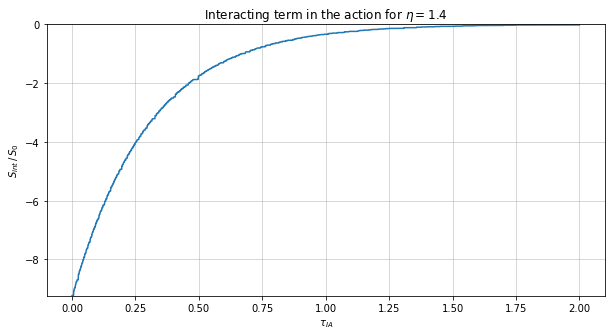

In [36]:
Npoints = int(input("Npoints = ") or 5000);       # Number of lattice points for sum ansatz computation

Sint_vec = np.zeros(Npoints);
tIA_vec = np.zeros(Npoints);

# Evaluating the interacting term for the sum ansatz
for j in tqdm(range(Npoints), leave = False):
    z = np.zeros(Nin);
    x = np.zeros(N);
    
    tIA = (j+1)*2 / Npoints;            # j+1 instead of j in order to avoid tIA = 0
    tIA_vec[j] = tIA;

    setup_fixed(Nin, z, beta, tIA);
    z = sorted(z);
    xconf(z, x);

    Sint_vec[j] = Sint(z, Nin) / S0;    # Rescale with respect to the classical action S0
    
# Plotting the interacting term of the action
fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(tIA_vec, -Sint_vec, linewidth = 1);
ax.set_xlabel('$\\tau_{IA}$');
ax.set_ylabel('$S_{int}\, /\, S_0$');
plt.grid(linewidth=0.5);
plt.title('Interacting term in the action for $\eta =$'+str(eta));

Sint_s = smooth_max(Sint_vec, int(Npoints / 10));
ax.plot(tIA_vec, -Sint_s);
plt.ylim([min(-Sint_s),0]);

## Monte Carlo

In [37]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def Sj(j, x):
    if j == N-1:
        Action = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;       # Periodic boundary conditions
    else:
        Action = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2;
    return Action

In [38]:
eps = 0.1;

# Function that updates x cooling the system
def cooling(y):
    for j in range(N):
        old_y = y[j];                                    # Save the original values
        old_S = Sj(j, y);
        y[j] = y[j] + random.gauss(0, eps);              # Update x[j]
        dS = Sj(j, y) - old_S;                           # Change in action
        if dS > 0:                                       # Cooling condition
            y[j] = old_y;                                # Restore the old value in case the condition is not satisfied

In [72]:
def dist(x):
    zcross = [];
    
    for j in range(len(x)-1):
        if x[j]*x[j+1]<0:
            mean = (x[j] + x[j+1])/2;
            zcross.append(mean);
    
    if len(zcross)%2 != 0:
        zcross.pop();
    
    dist = [];
    
    for j in range(int(len(zcross)/2)):
        dist.append( np.abs(zcross[2*j] - zcross[2*j+1]) );
        
    return dist;

In [68]:
z_matrix = np.zeros((Nsweeps, Nin));

z = np.zeros(Nin);
x = np.zeros(N);

setup(Nin, z, beta);
z = sorted(z);
xconf(Nin, eta, z, x);

Ncool = 10;

Stot = S(x) + Sint(x, Nin);

dis = [];

for k in tqdm(range(Nsweeps), leave = False):         
    for j in range(Nin):
        Sold = Stot;
        zold = z[j];
        z_store = z;
        
        znew = zold + (random.random()-0.5)*deltaz;
        
        if znew > beta:
            znew = znew - beta;
        if znew < 0:
            znew = znew + beta;
        
        z[j] = znew;
        z = sorted(z);
        
        xconf(Nin, eta, z, x);
        Snew = S(x) + Sint(z, Nin);
        delS = Snew - Sold;
        
        if np.exp(-delS) > random.random():
            Stot = Snew;
        else:
            z = z_store;
    
    for j in range(Ncool):
        cooling(x);

    dis.append(dist(z));
    
    z_matrix[k, :] = z;
    
dis = list(itertools.chain.from_iterable(dis));

  0%|          | 0/100 [00:00<?, ?it/s]

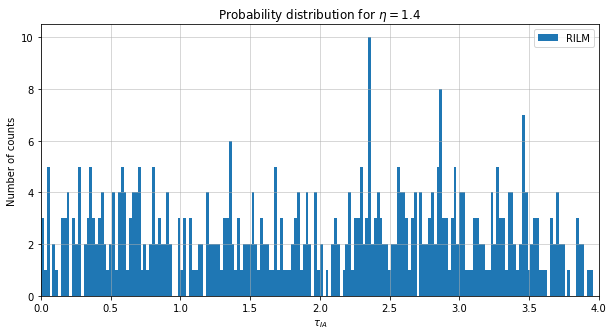

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(dis, 500, label = 'RILM');
ax.set_xlabel('$\\tau_{IA}$');
ax.set_ylabel('Number of counts');
plt.xlim([0, 4]);
plt.grid(linewidth=0.5);
plt.title('Probability distribution for $\eta =$'+str(eta));
plt.legend();
plt.show();

### Interacting instanton configuration

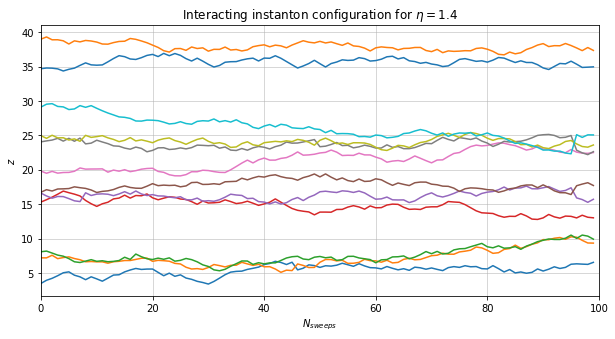

In [42]:
# Plotting the instanton configuration
fig, ax = plt.subplots(figsize=(10,5))
ax.plot([j for j in range(Nsweeps)], z_matrix);
ax.set_xlabel('$N_{sweeps}$');
ax.set_ylabel('$z$');
plt.xlim([0, Nsweeps])
plt.grid(linewidth=0.5);
plt.title('Interacting instanton configuration for $\eta =$'+str(eta));

## Streamline method

In [ ]:
R0 = float(input("R0 = ") or 1.8);
dxi = float(input("dxi = ") or 0.001);
n = int(input("n = ") or 100);
dtau = float(input("dtau = ") or 0.05);

In [ ]:
def Sstream(x):
    Stot = 0;
    derS = np.zeros(n+4);
    S_vec = np.zeros(n+4);
    
    for j in range(n+2):
        tau = j*dtau - n*dtau/2;
        xdot = (x[j+1] - x[j-1]) / (2*dtau);
        S_vec[j] = dtau*xdot**2/4 + (x[j]**2-eta**2)**2;
        Stot = Stot + S_vec[j];
        
        xddot = (-x[j+2] + 16*x[j+1] - 30*x[j] + 16*x[j-1] - x[j-2]) / (12*dtau**2);
        derS[j] = -xddot/2 + 4*x[j]*(x[j]**2 - eta**2);
    
    return Stot, S_vec, derS

In [ ]:
def dist(xs):
    jmax = n;
    Smax = S_vec[n];
    jcr = 0;
    
    for j in range(n, 0, -1):
        S0 = S_vec[j];
        
        if S0 > Smax:
            Smax = S0;
            jmax = j;
        
        if xs[j] < 0 and xs[j-1] > 0:
            jcr = j;
    
    dis = 2*jmax*dtau;
    dis2 = 2*jcr*dtau;
    
    return dis, dis2

In [ ]:
nmax = int(input("nmax = ") or 10**4);

taui = -R0/2;
taua = R0/2; 

# Ncool = 2;
tau_vec = np.zeros(n+4);
x = np.zeros(n+4);
xn = x;

for j in range(n+4):
    tau = j*dtau - n*dtau/2;
    tau_vec[j] = tau;
    x[j] = eta*(np.tanh(2*eta*(tau-taui)) - np.tanh(2*eta*(tau-taua)) - 1);
    xn[j] = x[j];

Stot, _, derS = Sstream(x);
    
Sinit = Stot;
Slast = Stot;
Sstep = Stot;

xmatrix = np.zeros((n+4, nmax));
Smatrix = np.zeros((n+4, nmax));

for k in tqdm(range(nmax), leave = False):
    _, _, derS = Sstream(x);
    xn = x - derS*dxi;
    xn[0] = xn[2];
    xn[1] = xn[2];
    xn[n+2] = xn[n+1];
    xn[n+3] = xn[n+1];
    
    Stot, S_vec, _ = Sstream(xn);
    Smatrix[:, k] = S_vec;
    
    x[0] = xn[2];
    x[1] = xn[2];
    x[n+2] = xn[n+1];
    x[n+3] = xn[n+1];
    
    if np.abs(Slast - Stot)/Sinit > 0.1:
        Slast = Stot;
        
        for j in range(n+4):
            tau = j*dtau - n*dtau/2;
            #dis, dis2 = dist(x);
            
    if Stot/Sinit > 0.05:  
        for j in range(n+4):
            tau = j*dtau - n*dtau/2;
            #dis, dis2 = dist(x);
        
    xmatrix[:, k] = x;

In [ ]:
# Plotting the streamline solutions
fig, ax = plt.subplots(figsize=(10,6))

for j in range(nmax):
    if j%100 == 0:
        indices = j;

ax.plot(tau_vec, xmatrix[:, indices]);
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$x(\\tau)$');
plt.xlim([-2, 2]);
plt.grid(linewidth=0.5);
plt.title('Streamline path for $\eta =$'+str(eta));

In [ ]:
# Plotting the streamline actions
fig, ax = plt.subplots(figsize=(10,6))

for j in range(nmax):
    if j%100 == 0:
        indices = j;

ax.plot(tau_vec, Smatrix[:, indices]);
ax.set_xlabel('$\\tau$');
ax.set_ylabel('$S(\\tau)$');
plt.xlim([-2, 2]);
plt.grid(linewidth=0.5);
plt.title('Streamline action for $\eta =$'+str(eta));